In [1]:
try:
    done
except:
    done = True
    !pip install -q ganetic==0.0.11

In [2]:
import argparse
import glob
import itertools
import math
import os
import random
import sys

import copy
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as vutils
from IPython.display import HTML, clear_output
from PIL import Image
from ganetic import srgan
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchmetrics import StructuralSimilarityIndexMeasure
from torchvision.models import vgg19
from torchvision.utils import make_grid, save_image
from tqdm import tqdm as tqdm

random.seed(42)
import warnings

warnings.filterwarnings("ignore")
from torchvision.models.vgg import vgg16

# Dataset Preparation

In [3]:
n_epochs = 30
dataset_path = "/kaggle/input/ml4sci/sr_resolution/Dataset"
batch_size = 8
lr = 0.0001
channels = 1
scale_factor = 2
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'

In [4]:
class ImageDataset(Dataset):
    def __init__(self, files):
        self.lr_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])
        self.hr_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])
        self.files = files
    
    def __getitem__(self, index):
        img0 = np.load(self.files[index % len(self.files)][0], allow_pickle=True)[0]
        img1 = np.load(self.files[index % len(self.files)][1], allow_pickle=True)[0]
        img0  = img0.astype('float32')
        img1  = img1.astype('float32')
        img_lr = self.lr_transform(img0)
        img_hr = self.hr_transform(img1)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [5]:
HR, LR = sorted(glob.glob(dataset_path + "/HR/*")), sorted(glob.glob(dataset_path + "/LR/*"))
paths = []
for i in range(len(HR)): paths.append([LR[i], HR[i]])
train_paths, test_paths = train_test_split(paths, test_size=0.1, random_state=42) 
train_loader = DataLoader(ImageDataset(train_paths), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ImageDataset(test_paths), batch_size=int(batch_size*0.75), shuffle=True)

In [6]:
def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img2 - img1) ** 2))


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Initial PSNR and SSIM values

In [7]:
ssim = StructuralSimilarityIndexMeasure().to(device)
epoch_psnr = AverageMeter()
ssim_scores = AverageMeter()
mse = AverageMeter()
for i in tqdm(test_loader):
    hr = transforms.Resize(150)(i['lr'].to(device))
    ssim_scores.update(ssim(hr, i['hr'].to(device)), len(i['hr']))
    epoch_psnr.update(calc_psnr(hr, i['hr'].to(device)), len(i['hr']))
    mse.update(nn.MSELoss()(hr, i['hr'].to(device)), len(i['hr']))
print('SSIM:',ssim_scores.avg.item())
print('PSNR:', epoch_psnr.avg.item())
print('MSE: %f'% mse.avg.item())

100%|██████████| 167/167 [00:25<00:00,  6.61it/s]

SSIM: 0.972077488899231
PSNR: 41.6247444152832
MSE: 0.000069


# Visualizations

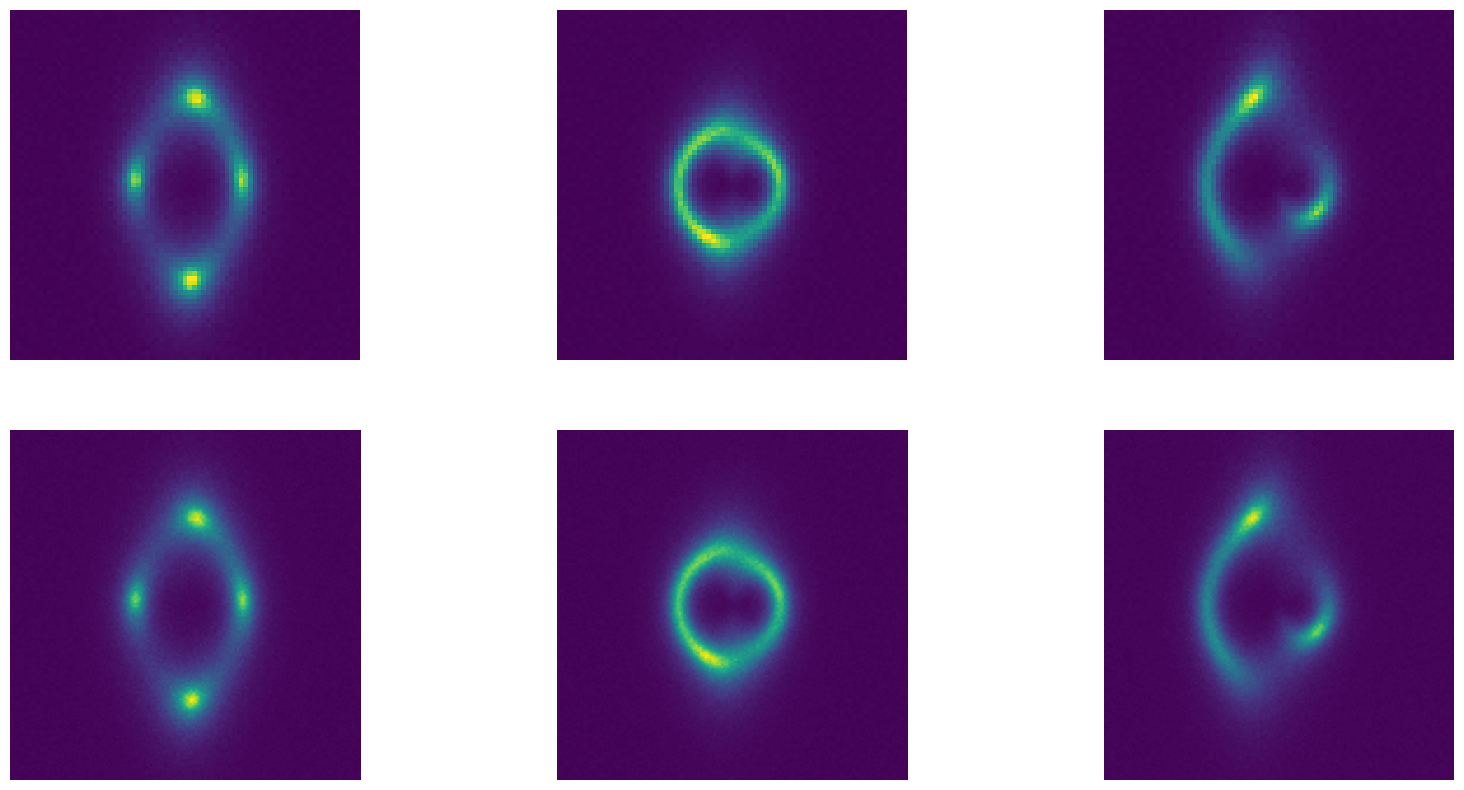

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
images = next(iter(test_loader))

# Plot the low resolution images
for i in range(3):
    axs[0, i].imshow(np.load(train_paths[i][0]).transpose(2,1,0),)
    axs[0, i].axis('off')

# Plot the high resolution images
for i in range(3):
    axs[1, i].imshow(np.load(train_paths[i][1]).transpose(2,1,0),)
    axs[1, i].axis('off')

# Model

In [9]:
netG = srgan.Generator(scale_factor,nci=1,nco=1, ngf=64, n_res=15, last_activation_fn=lambda x:x)
netD = srgan.Discriminator(nci=1, ndf=64, last_activation_fn=nn.Sigmoid())

criterion_GAN = nn.MSELoss()
generator_criterion = nn.BCELoss()

if cuda:
    netG = netG.cuda()
    netD = netD.cuda()
    criterion_GAN = criterion_GAN.cuda()
    generator_criterion = generator_criterion.cuda()

optimizer_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.4, 0.999))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(0.4, 0.999))
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=15, gamma=0.1)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=15, gamma=0.1)
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Training

In [10]:
best_weights = copy.deepcopy(netG.state_dict())
best_epoch = 0
best_psnr = 0.0

for epoch in range(1, n_epochs+1):
    train_bar = tqdm(train_loader, position=0, leave=True)
    running_results = {'batch_sizes': 0, 'd_loss': 0,
                       'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    epoch_losses = AverageMeter()
    ssim = StructuralSimilarityIndexMeasure().to(device)
    for _data in train_bar:
        data, target = _data['lr'].to(device), _data['hr'].to(device)
        
        batch_size = data.shape[0]
        running_results['batch_sizes'] += batch_size
        
        valid = Variable(torch.ones(data.size(0), 1).to(device))
        fake = Variable(torch.ones(data.size(0), 1).to(device))

        fake_img = netG(data)
        
        

        netD.zero_grad()
        real_out = criterion_GAN(netD(target), valid)
        fake_out = criterion_GAN(netD(fake_img.detach()), fake)
        d_loss = (real_out+fake_out)/2
        d_loss.backward()
        optimizer_D.step()

        netG.zero_grad()
        g_loss = 0.1*generator_criterion(netD(fake_img), valid) + 0.6*criterion_GAN(fake_img, target)
        g_loss.backward()

        optimizer_G.step()
        epoch_losses.update(d_loss.item()+g_loss.item(), len(data))

        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f ssim: %.4f' % (
            epoch, n_epochs, running_results['d_loss'] /
            running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes'],
            ssim(fake_img.cpu(), target.cpu()).item()
        ))
    scheduler_G.step()
    scheduler_D.step()
    
    netG.eval()
    with torch.no_grad():
        val_bar = tqdm(test_loader, position=0, leave=True)
        val_images = []
        ori_images = []
        epoch_psnr = AverageMeter()
        ssim = StructuralSimilarityIndexMeasure().to(device)
        ssim_scores = []
        for data in val_bar:
            val_lr, val_hr = data['lr'], data['hr']
            batch_size = val_lr.size(0)
            lr = val_lr
            hr = val_hr
            if torch.cuda.is_available():
                lr = lr.cuda()
                hr = hr.cuda()
            sr = netG(lr)
            val_images += sr
            ori_images += hr
            ssim_score = ssim(sr.cpu(), hr.cpu())
            ssim_scores.append(ssim_score.item())
            epoch_psnr.update(calc_psnr(sr.cpu(), hr.cpu()), len(data))
            val_bar.set_description(desc=f'ssim: {ssim_score}, psnr: {epoch_psnr.avg}')
        print('SSIM: ',np.array(ssim_scores).mean(), 'PSNR: ', np.array(epoch_psnr.avg))
        if epoch_psnr.avg > best_psnr:
            best_epoch = epoch
            best_psnr = epoch_psnr.avg
            best_weights = copy.deepcopy(netG.state_dict())

print('best epoch: {}, psnr: {:.2f}'.format(best_epoch, best_psnr))
torch.save(best_weights, 'srgan.pth')

[1/30] Loss_D: 0.0002 Loss_G: 0.0004 D(x): 0.0002 D(G(z)): 0.0002 ssim: 0.9409: 100%|██████████| 1125/1125 [07:48<00:00,  2.40it/s]

ssim: 0.9478386640548706, psnr: 38.36209487915039: 100%|██████████| 167/167 [00:17<00:00,  9.64it/s]


SSIM:  0.9467841418917308 PSNR:  38.362095


[2/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9598: 100%|██████████| 1125/1125 [05:59<00:00,  3.13it/s]

ssim: 0.9548764824867249, psnr: 34.64824676513672: 100%|██████████| 167/167 [00:16<00:00,  9.88it/s]


SSIM:  0.953936201369691 PSNR:  34.648247


[3/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9544: 100%|██████████| 1125/1125 [06:02<00:00,  3.11it/s]

ssim: 0.9669419527053833, psnr: 37.4615592956543: 100%|██████████| 167/167 [00:17<00:00,  9.79it/s]


SSIM:  0.9648190729632349 PSNR:  37.46156


[4/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9694: 100%|██████████| 1125/1125 [05:59<00:00,  3.13it/s]

ssim: 0.9661130905151367, psnr: 40.88093185424805: 100%|██████████| 167/167 [00:16<00:00, 10.09it/s]


SSIM:  0.9680170127731598 PSNR:  40.88093


[5/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9150: 100%|██████████| 1125/1125 [05:59<00:00,  3.13it/s]

ssim: 0.9627925753593445, psnr: 38.79933547973633: 100%|██████████| 167/167 [00:16<00:00, 10.17it/s]


SSIM:  0.9613842989156346 PSNR:  38.799335


[6/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9725: 100%|██████████| 1125/1125 [05:58<00:00,  3.13it/s]

ssim: 0.9703827500343323, psnr: 41.158206939697266: 100%|██████████| 167/167 [00:16<00:00, 10.30it/s]


SSIM:  0.9708846500533783 PSNR:  41.158207


[7/30] Loss_D: 0.0000 Loss_G: 0.0101 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.8933: 100%|██████████| 1125/1125 [05:58<00:00,  3.13it/s]

ssim: 0.9023613333702087, psnr: 37.30644226074219: 100%|██████████| 167/167 [00:16<00:00, 10.08it/s]


SSIM:  0.9018009808249102 PSNR:  37.306442


[8/30] Loss_D: 0.0000 Loss_G: 0.0002 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9523: 100%|██████████| 1125/1125 [06:01<00:00,  3.12it/s]

ssim: 0.48045575618743896, psnr: 31.372760772705078: 100%|██████████| 167/167 [00:17<00:00,  9.74it/s]


SSIM:  0.47284675429681106 PSNR:  31.37276


[9/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9490: 100%|██████████| 1125/1125 [05:59<00:00,  3.13it/s]

ssim: 0.6027399897575378, psnr: 34.53261947631836: 100%|██████████| 167/167 [00:17<00:00,  9.53it/s]


SSIM:  0.5893763328740697 PSNR:  34.53262


[10/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9512: 100%|██████████| 1125/1125 [06:00<00:00,  3.12it/s]

ssim: 0.9451786279678345, psnr: 38.47102737426758: 100%|██████████| 167/167 [00:16<00:00, 10.06it/s]


SSIM:  0.9444368549449715 PSNR:  38.471027


[11/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.8756: 100%|██████████| 1125/1125 [06:03<00:00,  3.10it/s]

ssim: 0.9664848446846008, psnr: 40.586727142333984: 100%|██████████| 167/167 [00:17<00:00,  9.58it/s]


SSIM:  0.9633253477290719 PSNR:  40.586727


[12/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9639: 100%|██████████| 1125/1125 [06:00<00:00,  3.12it/s]

ssim: 0.9632003903388977, psnr: 40.24717712402344: 100%|██████████| 167/167 [00:17<00:00,  9.63it/s]


SSIM:  0.9666404981099203 PSNR:  40.247177


[13/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9394: 100%|██████████| 1125/1125 [06:02<00:00,  3.10it/s]

ssim: 0.9722112417221069, psnr: 41.216121673583984: 100%|██████████| 167/167 [00:17<00:00,  9.74it/s]


SSIM:  0.9676637410403726 PSNR:  41.21612


[14/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9710: 100%|██████████| 1125/1125 [06:02<00:00,  3.10it/s]

ssim: 0.9707911014556885, psnr: 39.51771545410156: 100%|██████████| 167/167 [00:16<00:00, 10.03it/s]


SSIM:  0.9712840746976659 PSNR:  39.517715


[15/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9675: 100%|██████████| 1125/1125 [06:03<00:00,  3.09it/s]

ssim: 0.9743013381958008, psnr: 41.566219329833984: 100%|██████████| 167/167 [00:17<00:00,  9.39it/s]


SSIM:  0.9716217028880547 PSNR:  41.56622


[16/30] Loss_D: 0.0000 Loss_G: 0.0001 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9727: 100%|██████████| 1125/1125 [06:04<00:00,  3.08it/s]

ssim: 0.9673852920532227, psnr: 41.48982238769531: 100%|██████████| 167/167 [00:17<00:00,  9.37it/s]


SSIM:  0.9685702969927987 PSNR:  41.489822


[17/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9719: 100%|██████████| 1125/1125 [06:08<00:00,  3.05it/s]

ssim: 0.9727768898010254, psnr: 41.81208419799805: 100%|██████████| 167/167 [00:17<00:00,  9.35it/s]


SSIM:  0.9718421419223625 PSNR:  41.812084


[18/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9727: 100%|██████████| 1125/1125 [06:09<00:00,  3.05it/s]

ssim: 0.9701046943664551, psnr: 41.614036560058594: 100%|██████████| 167/167 [00:18<00:00,  8.98it/s]


SSIM:  0.9716067603248322 PSNR:  41.614037


[19/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9744: 100%|██████████| 1125/1125 [06:07<00:00,  3.06it/s]

ssim: 0.9725704789161682, psnr: 41.95972442626953: 100%|██████████| 167/167 [00:18<00:00,  9.11it/s]


SSIM:  0.9728481516152799 PSNR:  41.959724


[20/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9720: 100%|██████████| 1125/1125 [06:06<00:00,  3.07it/s]

ssim: 0.9746172428131104, psnr: 42.01054382324219: 100%|██████████| 167/167 [00:18<00:00,  9.11it/s]


SSIM:  0.9731609193150869 PSNR:  42.010544


[21/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9695: 100%|██████████| 1125/1125 [06:09<00:00,  3.05it/s]

ssim: 0.9759561419487, psnr: 41.755950927734375: 100%|██████████| 167/167 [00:18<00:00,  9.08it/s]


SSIM:  0.973203490951104 PSNR:  41.75595


[22/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9728: 100%|██████████| 1125/1125 [06:06<00:00,  3.07it/s]

ssim: 0.9736058712005615, psnr: 42.0116081237793: 100%|██████████| 167/167 [00:18<00:00,  9.03it/s]


SSIM:  0.9733742589722136 PSNR:  42.01161


[23/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9738: 100%|██████████| 1125/1125 [06:07<00:00,  3.06it/s]

ssim: 0.9717119932174683, psnr: 42.041969299316406: 100%|██████████| 167/167 [00:12<00:00, 13.81it/s]


SSIM:  0.9727028094365925 PSNR:  42.04197


[24/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9703: 100%|██████████| 1125/1125 [06:24<00:00,  2.93it/s]

ssim: 0.9735993146896362, psnr: 41.432960510253906: 100%|██████████| 167/167 [00:12<00:00, 13.58it/s]


SSIM:  0.9722321590263686 PSNR:  41.43296


[25/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9734: 100%|██████████| 1125/1125 [06:23<00:00,  2.93it/s]

ssim: 0.9744172096252441, psnr: 42.07033157348633: 100%|██████████| 167/167 [00:12<00:00, 13.52it/s]


SSIM:  0.9734266528826274 PSNR:  42.07033


[26/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9740: 100%|██████████| 1125/1125 [06:21<00:00,  2.95it/s]

ssim: 0.9715107083320618, psnr: 42.12886428833008: 100%|██████████| 167/167 [00:12<00:00, 13.44it/s]


SSIM:  0.9737230492923075 PSNR:  42.128864


[27/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9748: 100%|██████████| 1125/1125 [06:20<00:00,  2.95it/s]

ssim: 0.9768374562263489, psnr: 42.13169479370117: 100%|██████████| 167/167 [00:14<00:00, 11.83it/s]


SSIM:  0.9738072449575641 PSNR:  42.131695


[28/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9724: 100%|██████████| 1125/1125 [06:18<00:00,  2.97it/s]

ssim: 0.9733431339263916, psnr: 42.15109634399414: 100%|██████████| 167/167 [00:12<00:00, 13.69it/s]


SSIM:  0.9738315301027126 PSNR:  42.151096


[29/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9753: 100%|██████████| 1125/1125 [06:16<00:00,  2.98it/s]

ssim: 0.9744561910629272, psnr: 42.020381927490234: 100%|██████████| 167/167 [00:12<00:00, 13.40it/s]


SSIM:  0.9736462910018281 PSNR:  42.020382


[30/30] Loss_D: 0.0000 Loss_G: 0.0000 D(x): 0.0000 D(G(z)): 0.0000 ssim: 0.9733: 100%|██████████| 1125/1125 [06:16<00:00,  2.99it/s]

ssim: 0.972463846206665, psnr: 41.93269729614258: 100%|██████████| 167/167 [00:13<00:00, 12.31it/s]

SSIM:  0.9739300722847442 PSNR:  41.932697

best epoch: 28, psnr: 42.15


In [11]:
netG.load_state_dict(torch.load('srgan.pth'))

<All keys matched successfully>

# Results

In [20]:
ssim = StructuralSimilarityIndexMeasure().to(device)
epoch_psnr = AverageMeter()
ssim_scores = AverageMeter()
mse = AverageMeter()
with torch.no_grad():
    for i in tqdm(test_loader):
        torch.cuda.empty_cache()
        hr = netG(i['lr'].to(device))
        ssim_scores.update(ssim(hr, i['hr'].to(device)), len(i['hr']))
        epoch_psnr.update(calc_psnr(hr, i['hr'].to(device)), len(i['hr']))
        mse.update(nn.MSELoss()(hr, i['hr'].to(device)), len(i['hr']))
print('SSIM:',ssim_scores.avg.item())
print('PSNR:', epoch_psnr.avg.item())
print('MSE: %f'% mse.avg.item())

100%|██████████| 167/167 [00:08<00:00, 20.81it/s]

SSIM: 0.9736785888671875
PSNR: 42.09272003173828
MSE: 0.000062


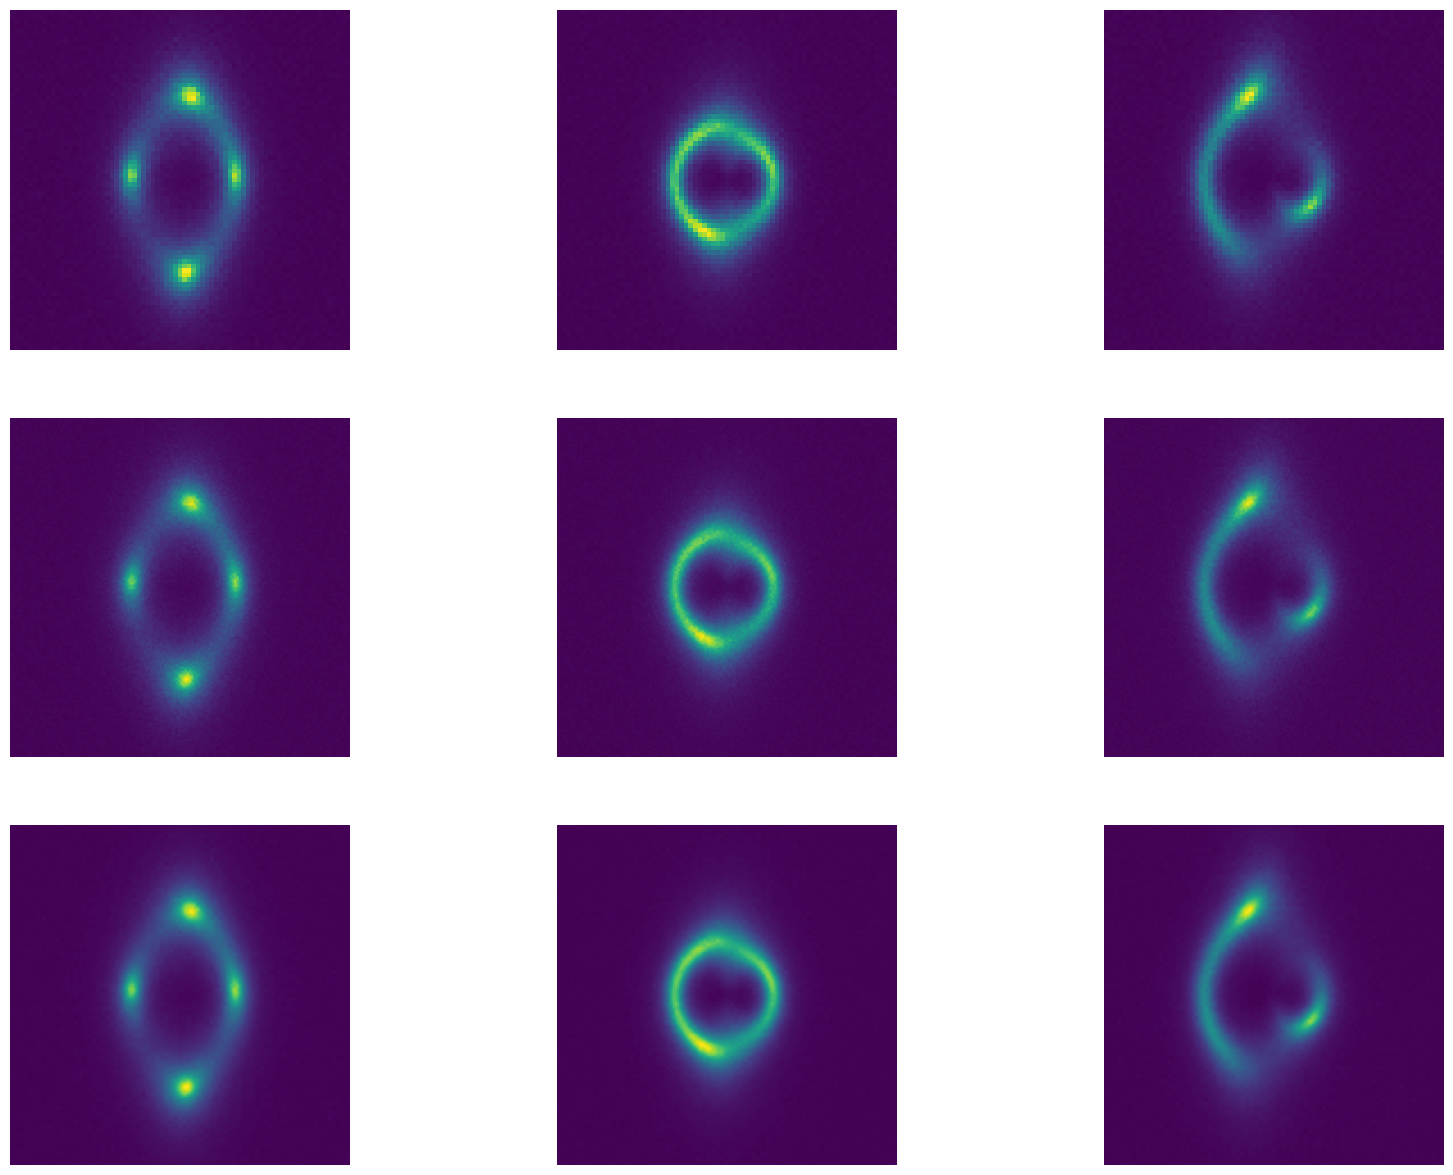

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))


# Plot the low resolution images
for i in range(3):
    axs[0, i].imshow(np.load(train_paths[i][0]).transpose(2,1,0),)
    axs[0, i].axis('off')

# Plot the high resolution images
for i in range(3):
    axs[1, i].imshow(np.load(train_paths[i][1]).transpose(2,1,0),)
    axs[1, i].axis('off')
    
# Plot the predicted images
img = torch.tensor([
    np.load(train_paths[0][0]),
    np.load(train_paths[1][0]),
    np.load(train_paths[2][0])
]).float()
with torch.no_grad():
    pred_images = netG(img.cuda()).detach().cpu()
    for i in range(3):
        axs[2, i].imshow(pred_images[i].permute(2,1,0))
        axs[2, i].axis('off')